In [1]:
import pandas as pd
import IPython.display as ipd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils import shuffle
from smds import SMDS
import numpy as np
from keras import models, layers
from utils import TestModel, min_max_scaling, show_matrix
from score import Audio
import matplotlib.pyplot as plt
import os

## Prepair data

In [2]:
data = pd.read_csv("./data/gtzan/features_30_sec.csv")
genres = data[["filename", "label"]]
ipd.display(data)

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0    blues.00000.wav  661794          0.350088         0.088757  0.130228   
1    blues.00001.wav  661794          0.340914         0.094980  0.095948   
2    blues.00002.wav  661794          0.363637         0.085275  0.175570   
3    blues.00003.wav  661794          0.404785         0.093999  0.141093   
4    blues.00004.wav  661794          0.308526         0.087841  0.091529   
..               ...     ...               ...              ...       ...   
995   rock.00095.wav  661794          0.352063         0.080487  0.079486   
996   rock.00096.wav  661794          0.398687         0.075086  0.076458   
997   rock.00097.wav  661794          0.432142         0.075268  0.081651   
998   rock.00098.wav  661794          0.362485         0.091506  0.083860   
999   rock.00099.wav  661794          0.358401         0.085884  0.054454   

      rms_var  spectral_centroid_mean  spectral_centroid_var  \
0    0.002827             1784.165850          129774.064525   
1    0.002373             1530.176679          375850.073649   
2    0.002746             1552.811865          156467.643368   
3    0.006346             1070.106615          184355.942417   
4    0.002303             1835.004266          343399.939274   
..        ...                     ...                    ...   
995  0.000345             2008.149458          282174.689224   
996  0.000588             2006.843354          182114.709510   
997  0.000322             2077.526598          231657.968040   
998  0.001211             1398.699344          240318.731073   
999  0.000336             1609.795082          422203.216152   

     spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0                2002.449060            85882.761315  ...   52.420910   
1                2039.036516           213843.755497  ...   55.356403   
2                1747.702312            76254.192257  ...   40.598766   
3                1596.412872           166441.494769  ...   44.427753   
4                1748.172116            88445.209036  ...   86.099236   
..                       ...                     ...  ...         ...   
995              2106.541053            88609.749506  ...   45.050526   
996              2068.942009            82426.016726  ...   33.851742   
997              1927.293153            74717.124394  ...   33.597008   
998              1818.450280           109090.207161  ...   46.324894   
999              1797.213044           120115.632927  ...   59.167755   

     mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  \
0      -1.690215   36.524071    -0.408979   41.597103    -2.303523   
1      -0.731125   60.314529     0.295073   48.120598    -0.283518   
2      -7.729093   47.639427    -1.816407   52.382141    -3.439720   
3      -3.319597   50.206673     0.636965   37.319130    -0.619121   
4      -5.454034   75.269707    -0.916874   53.613918    -4.404827   
..           ...         ...          ...         ...          ...   
995   -13.289984   41.754955     2.484145   36.778877    -6.713265   
996   -10.848309   39.395096     1.881229   32.010040    -7.461491   
997   -12.845291   36.367264     3.440978   36.001110   -12.588070   
998    -4.416050   43.583942     1.556207   34.331261    -5.041897   
999    -7.069775   73.760391     0.028346   76.504326    -2.025783   

     mfcc19_var  mfcc20_mean  mfcc20_var  label  
0     55.062923     1.221291   46.936035  blues  
1     51.106190     0.531217   45.786282  blues  
2     46.639660    -2.231258   30.573025  blues  
3     37.259739    -3.407448   31.949339  blues  
4     62.910812   -11.703234   55.195160  blues  
..          ...          ...         ...    ...  
995   54.866825    -1.193787   49.950665   rock  
996   39.196327    -2.795338   31.773624   rock  
997   42.502201    -2.106337   29.865515   rock  
998   47.227180    -3.590644   41.299088   rock  
999   72.189316     1.155239   49.662510   rock  


In [3]:
Y = data["label"]
# le = LabelEncoder()
# le.fit(Y)
# Y = le.transform(Y)

In [4]:
smd = SMDS()
smd_data = smd.load("./data/smds/smds.csv")
ipd.display(smd_data)

n_mfcc                           0                                             \
stat                      kurtosis       max       mean     median        min   
id  filename        tick                                                        
0   blues.00000.wav 0    -0.921429 -0.602207  -4.116866  -4.102283  -7.520702   
                    1    -1.034314 -1.877029  -7.598314  -7.186878 -13.353165   
                    2    -1.572501 -0.969917  -4.778881  -5.134876  -8.422367   
                    3    -0.464004 -6.557148 -19.352211 -13.589458 -44.356602   
                    4    -1.543346 -3.608807  -9.907966 -11.096891 -15.579109   
...                            ...       ...        ...        ...        ...   
999 rock.00099.wav  125  -1.668841 -6.418808  -8.240566  -8.720350  -9.642128   
                    126  -0.565443 -6.335140  -7.947320  -8.316345  -8.830395   
                    127  -1.263555 -7.196236  -7.737393  -7.752090  -8.294815   
                    128  -0.988667 -6.559055  -7.195686  -7.254095  -7.784954   
                    129   0.269860  0.000000  -1.463675   0.000000  -7.539124   

n_mfcc                                                1                        \
stat                          skew        std  kurtosis        max       mean   
id  filename        tick                                                        
0   blues.00000.wav 0     0.075946   2.036903  0.772538  -5.987366  -7.507081   
                    1    -0.174034   3.668512  0.112355  -4.566875  -5.301490   
                    2     0.114478   2.887686 -1.140482  -5.294666  -6.178790   
                    3    -1.017900  13.109632 -0.113993  -5.659710  -6.246984   
                    4     0.186728   4.365551 -0.444909  -5.034054  -6.183269   
...                            ...        ...       ...        ...        ...   
999 rock.00099.wav  125   0.288957   1.312025 -1.685759 -11.284740 -16.591238   
                    126   0.939037   0.814353  0.135143 -10.887753 -13.876005   
                    127   0.007978   0.383713  0.305037 -11.849773 -13.116172   
                    128   0.295401   0.383454 -0.891905 -12.233089 -13.124200   
                    129  -1.504257   2.929015  0.256183   0.000000  -2.852111   

n_mfcc                    ...         78                             79  \
stat                      ...        min      skew        std  kurtosis   
id  filename        tick  ...                                             
0   blues.00000.wav 0     ... -49.083920 -0.977847   5.134587 -1.160708   
                    1     ... -53.511654 -0.184655   5.826108 -1.315379   
                    2     ... -69.529617 -1.056008   8.996381  3.445230   
                    3     ... -59.234875  0.333952   6.306738 -0.488882   
                    4     ... -49.196671 -0.510006   5.263323  0.213930   
...                       ...        ...       ...        ...       ...   
999 rock.00099.wav  125   ... -54.167397 -0.335766   3.301470 -1.117706   
                    126   ... -80.000000 -1.005443  13.842562 -0.901133   
                    127   ... -69.031830 -0.722306   7.482690 -0.281512   
                    128   ... -61.854057  0.009870   6.562678 -0.681463   
                    129   ... -69.385315 -1.610976  24.341445  0.265864   

n_mfcc                                                                \
stat                            max       mean     median        min   
id  filename        tick                                               
0   blues.00000.wav 0    -35.698669 -43.202668 -43.486481 -49.926258   
                    1    -28.597214 -35.000878 -33.491056 -44.386990   
                    2    -34.679245 -42.391080 -40.910299 -66.542259   
                    3    -36.154251 -46.147050 -43.639938 -62.355431   
                    4    -30.756321 -46.553548 -42.001894 -78.969360   
...                             ...        ...        ...        ...   
999 rock.00099.wav  125  -41.10

In [5]:
def prepare_data(data: pd.DataFrame):
    grouped = data.groupby(by="id")
    
    cnn_data = [None]*len(grouped)
    ss = StandardScaler()
    for i, group in grouped:
        if i == 0: ss.fit(group)
        cnn_data[i] = ss.transform(group)
    cnn_data = np.expand_dims(cnn_data, axis=-1)
    return cnn_data
        

In [6]:
X = prepare_data(smd_data)
X, Y = shuffle(X, Y, random_state=1)

In [7]:
X.shape, Y.shape

((1000, 130, 560, 1), (1000,))

In [8]:
print(np.isnan(X).any())
print(np.isinf(X).any()) 
X = np.nan_to_num(X, nan=0.0, posinf=1.0, neginf=-1.0)  # 將 NaN 替換為 0，無窮大替換為合理的值
print(np.isnan(X).any())
print(np.isinf(X).any()) 

True
False
False
False


## Model 1

In [8]:
def model_1():
    input_dim = (130, 560)
    encoding_dim = 10
    
    input_layer = layers.Input(shape = input_dim)
    x = layers.Masking(0.)(input_layer)
    x = layers.Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)
    
    encoded = layers.Dense(encoding_dim, activation='relu')(x)
    
    # Decoder
    x = layers.Dense(32, activation='relu')(encoded)
    x = layers.Dense(130 * 64, activation='relu')(x)  # 先還原回原始 Conv1D 層的輸出形狀
    x = layers.Reshape((130, 64))(x)  # 將其 reshape 回 (sequence_length, num_filters)
    decoded = layers.Conv1D(filters=560, kernel_size=3, activation='sigmoid', padding='same')(x)

    encoder = models.Model(input_layer, encoded)
    autoencoder = models.Model(input_layer, decoded)
    
    return encoder, autoencoder

# Model - 1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
# Model - 2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
# Model - 3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


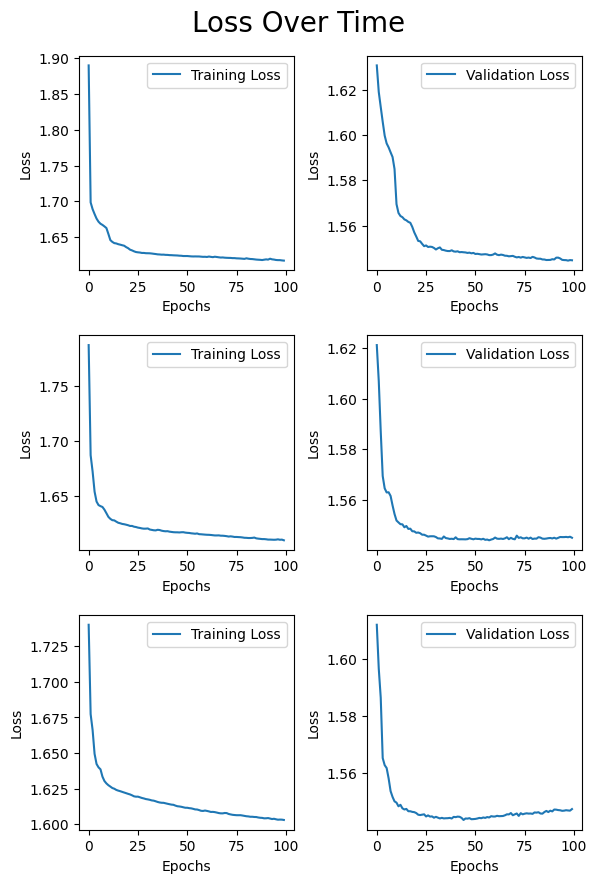

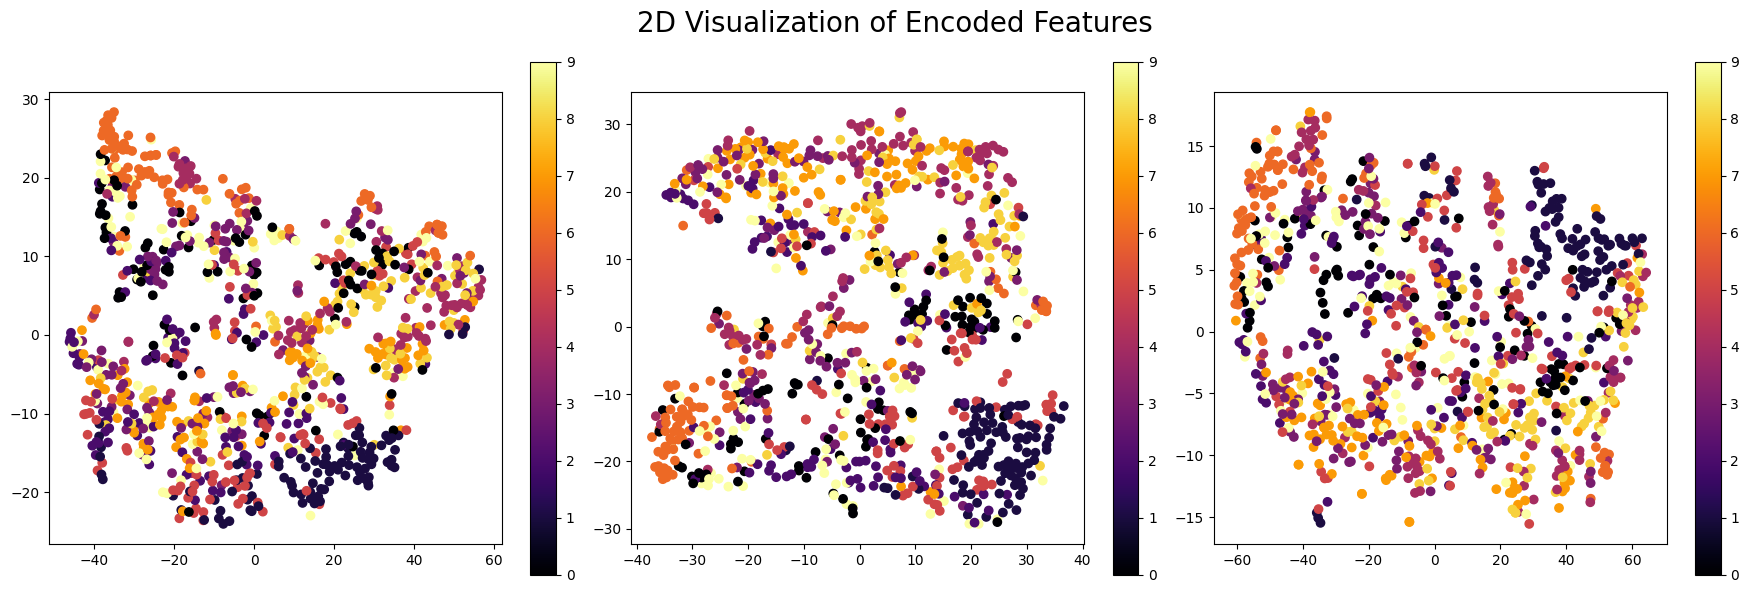

In [10]:
settings = (TestModel.ModelSettings(100, 64), TestModel.ModelSettings(100, 32), TestModel.ModelSettings(100, 16))
tm = TestModel(model_1, settings)
tm.test(X, X, validation_split=0.1, X_test=X, Y_test=Y, output_shape=10)

## Model 2

In [13]:
def model_2():
    input_dim = (130, 560)
    encoding_dim = 10
    
    input_layer = layers.Input(shape = input_dim)
    x = layers.Masking(0.)(input_layer)
    x = layers.Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
    x = layers.Conv1D(filters=32, kernel_size=3, activation='relu')(input_layer)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    
    encoded = layers.Dense(encoding_dim, activation='relu')(x)
    
    # Decoder
    x = layers.Dense(32, activation='relu')(encoded)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(130 * 32, activation='relu')(x)  # 先還原回原始 Conv1D 層的輸出形狀
    x = layers.Reshape((130, 32))(x)  # 將其 reshape 回 (sequence_length, num_filters)
    decoded = layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    decoded = layers.Conv1D(filters=560, kernel_size=3, activation='sigmoid', padding='same')(x)

    encoder = models.Model(input_layer, encoded)
    autoencoder = models.Model(input_layer, decoded)
    
    return encoder, autoencoder

# Model - 1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
# Model - 2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
# Model - 3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


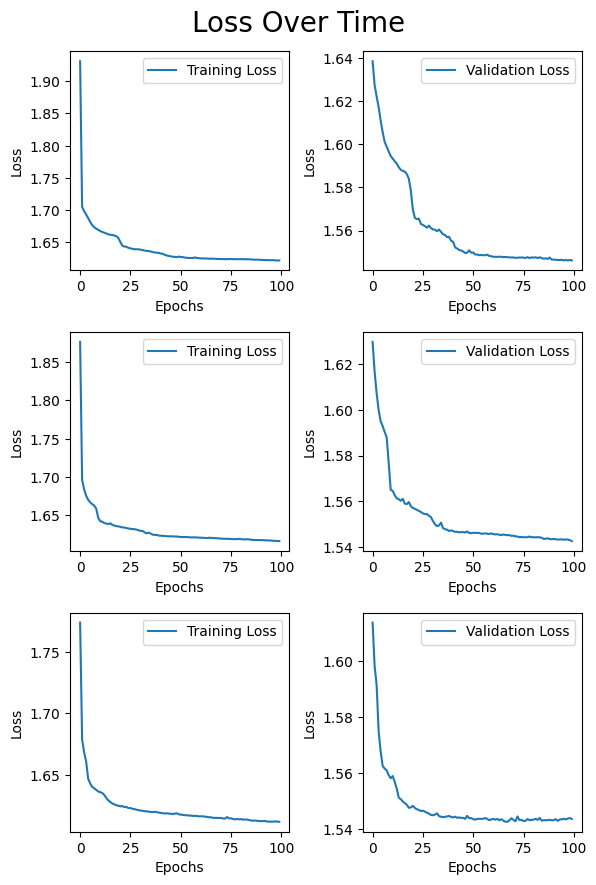

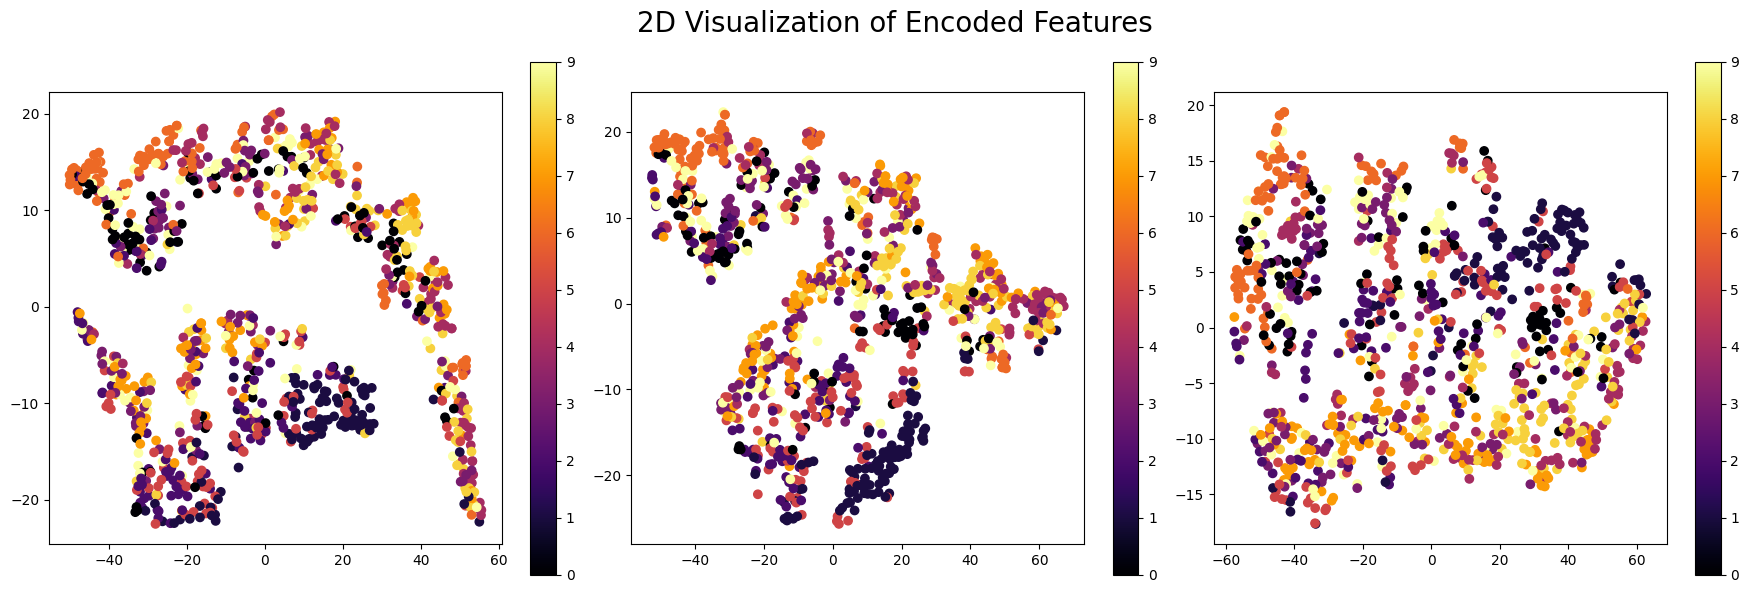

In [14]:
settings = (TestModel.ModelSettings(100, 64), TestModel.ModelSettings(100, 32), TestModel.ModelSettings(100, 16))
tm = TestModel(model_2, settings)
tm.test(X, X, validation_split=0.1, X_test=X, Y_test=Y, output_shape=10)

## Model 3

In [15]:
def model_3():
    input_dim = (130, 560)
    encoding_dim = 20
    
    input_layer = layers.Input(shape = input_dim)
    x = layers.Masking(0.)(input_layer)
    x = layers.Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
    x = layers.Conv1D(filters=32, kernel_size=3, activation='relu')(input_layer)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    
    encoded = layers.Dense(encoding_dim, activation='relu')(x)
    
    # Decoder
    x = layers.Dense(32, activation='relu')(encoded)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(130 * 32, activation='relu')(x)  # 先還原回原始 Conv1D 層的輸出形狀
    x = layers.Reshape((130, 32))(x)  # 將其 reshape 回 (sequence_length, num_filters)
    decoded = layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    decoded = layers.Conv1D(filters=560, kernel_size=3, activation='sigmoid', padding='same')(x)

    encoder = models.Model(input_layer, encoded)
    autoencoder = models.Model(input_layer, decoded)
    
    return encoder, autoencoder

# Model - 1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
# Model - 2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
# Model - 3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


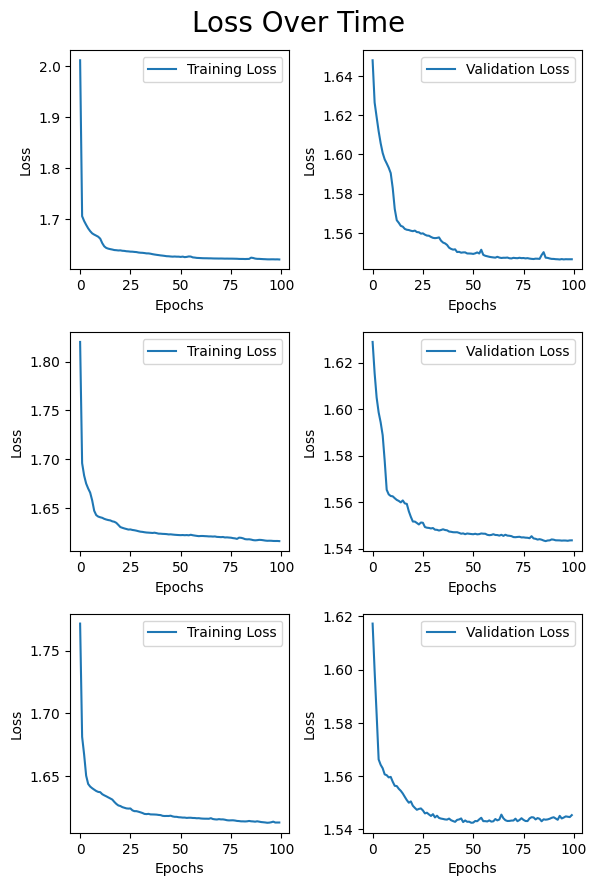

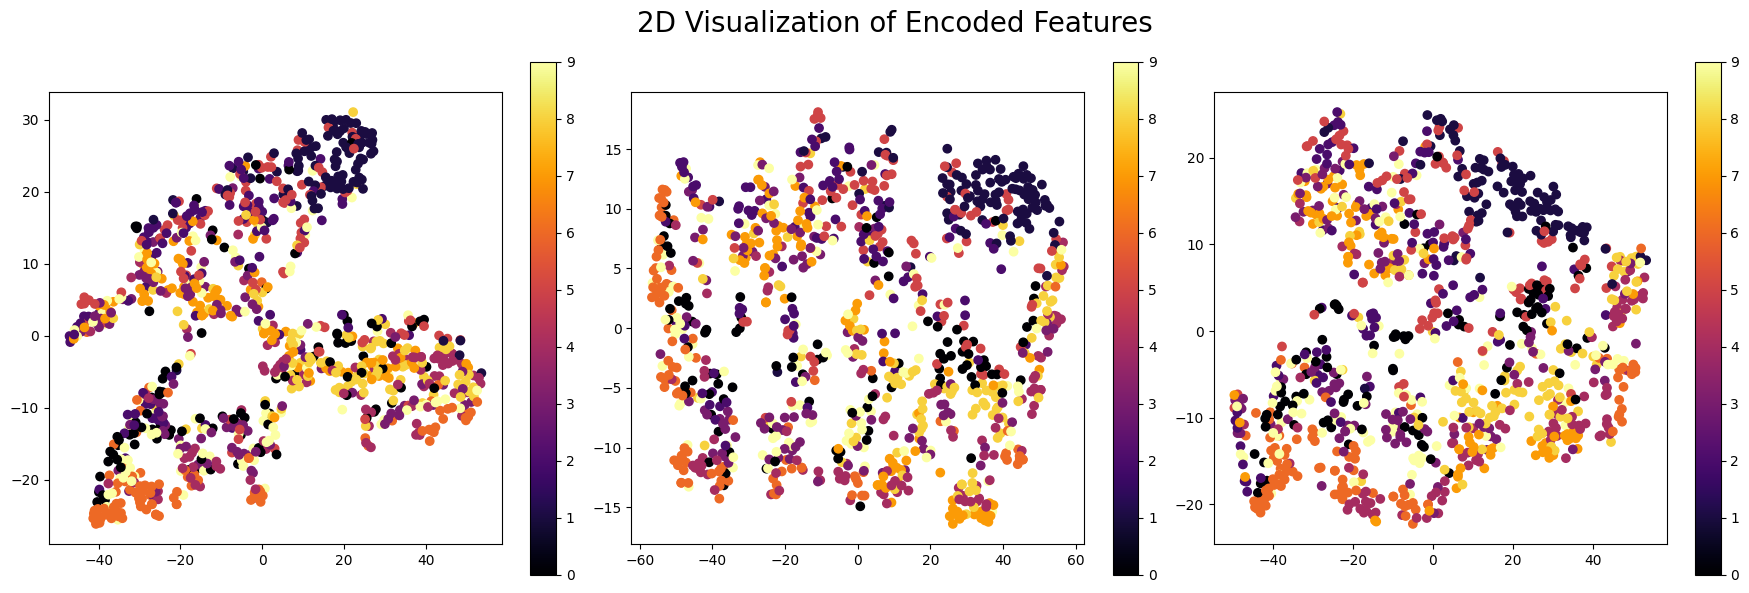

In [16]:
settings = (TestModel.ModelSettings(100, 64), TestModel.ModelSettings(100, 32), TestModel.ModelSettings(100, 16))
tm = TestModel(model_3, settings)
tm.test(X, X, validation_split=0.1, X_test=X, Y_test=Y, output_shape=20)

## Model 4

In [61]:
def model_4():
    input_shape=(130, 560)
    encoding_dim = 20
    
    # encoder
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv1D(32, 3, activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling1D(2, padding='same')(x) # shape[0] // 2
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2, padding='same')(x) # shape[0] // 2
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2, padding='same')(x) # shape[0] // 2
    
    # 壓縮成 latent space
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    encoded = layers.Dense(encoding_dim, activation='relu')(x)
    
    # decoder
    x = layers.Dense(64, activation='relu')
    x = layers.Dense(128 * (input_shape[0] // 8 + 1), activation='relu')(encoded)
    x = layers.Reshape((input_shape[0] // 8 + 1, 128))(x)  # 恢復卷積形狀
    x = layers.Conv1DTranspose(128, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(2)(x)
    x = layers.Conv1DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(2)(x)
    x = layers.Conv1DTranspose(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(2)(x)
    
    # 修正 shape
    x = layers.Cropping1D(cropping=(3, 3))(x)  # 將 shape 修正為 130, ...
    
    # 重構輸出
    decoded = layers.Conv1D(input_shape[1], 3, activation='sigmoid', padding='same')(x)
    
    encoder = models.Model(input_layer, encoded)
    autoencoder = models.Model(input_layer, decoded)
    return encoder, autoencoder

encoder, autoencoder = model_4()
autoencoder.summary()


Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 130, 560)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_40 (Conv1D)              │ (None, 130, 32)        │        53,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 65, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 65, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 33, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_42 (Conv1D)              │ (None, 33, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 17, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2176)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │       139,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 20)             │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2176)           │        45,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_8 (Reshape)             │ (None, 17, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_24             │ (None, 17, 128)        │        49,280 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_24 (UpSampling1D) │ (None, 34, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_25             │ (None, 34, 64)         │        24,640 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_25 (UpSampling1D) │ (None, 68, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_26             │ (None, 68, 32)         │         6,176 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_26 (UpSampling1D) │ (None, 136, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d_8 (Cropping1D)       │ (None, 130, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_43 (Conv1D)              │ (None, 130, 560)       │        54,320 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 405,444 (1.55 MB)

 Trainable params: 405,444 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

# Model - 1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
# Model - 2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
# Model - 3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


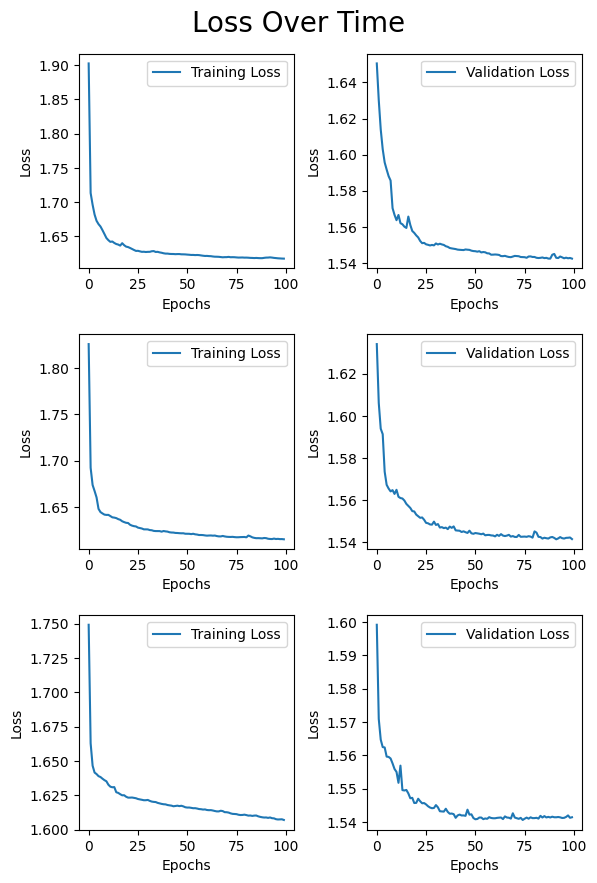

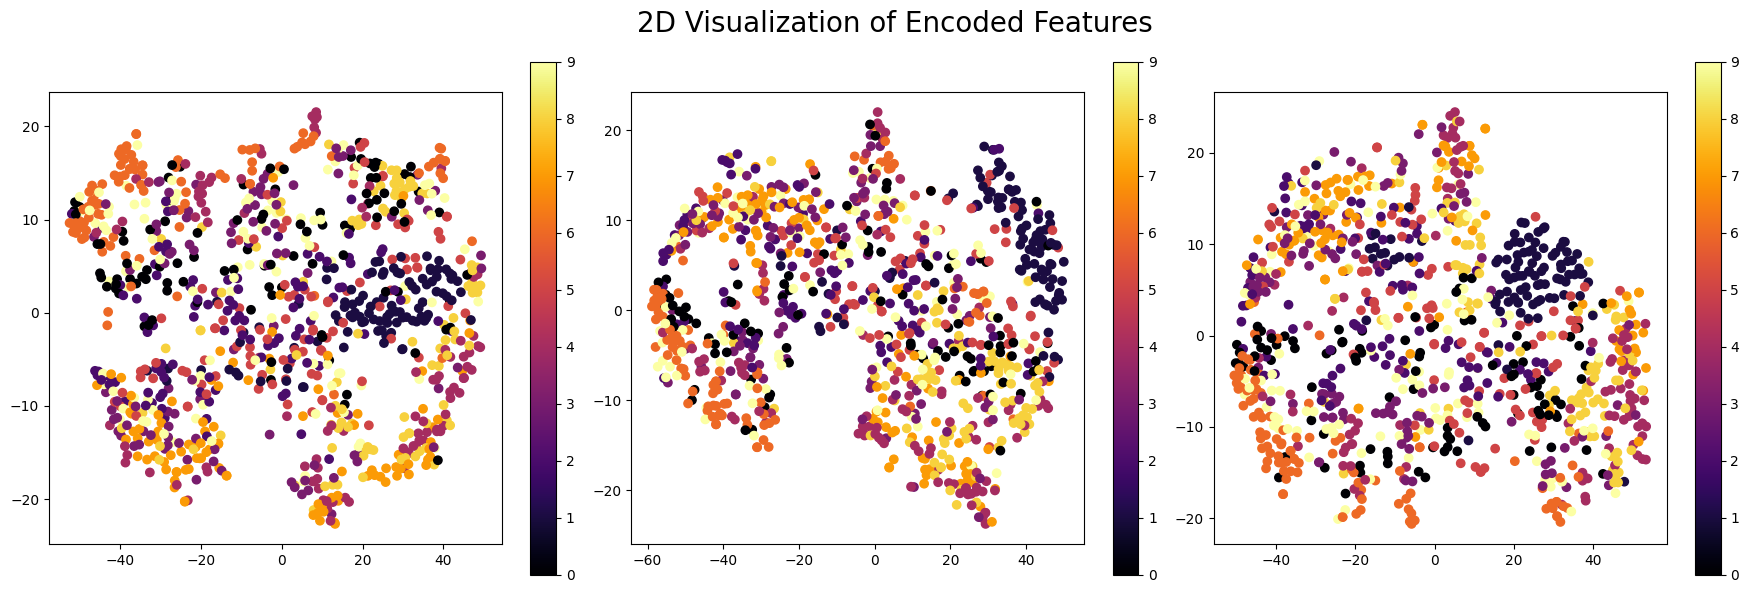

In [174]:
settings = (TestModel.ModelSettings(100, 64), TestModel.ModelSettings(100, 32), TestModel.ModelSettings(100, 16))
tm = TestModel(model_4, settings)
tm.test(X, X, validation_split=0.1, X_test=X, Y_test=Y, output_shape=20)

## Model 5

In [9]:
def model_5():
    input_shape = (130, 560)
    encoding_dim = 30
    
    # 編碼器
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv1D(32, 3, activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling1D(2, padding='same')(x)  # shape[0] // 2 -> 65
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2, padding='same')(x)  # shape[0] // 2 -> 33
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2, padding='same')(x)  # shape[0] // 2 -> 17
    
    # 壓縮成 latent space
    x = layers.Conv1D(encoding_dim, 3, activation='relu', padding='same')(x)
    encoded = layers.GlobalMaxPooling1D()(x)
    
    # 解碼器
    x = layers.Dense(encoding_dim)(encoded)
    x = layers.Dense(17 * encoding_dim, activation='relu')(x)  # 將大小恢復
    x = layers.Reshape((17, encoding_dim))(x)  # 恢復到 (17, encoding_dim)
    x = layers.Conv1DTranspose(128, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(2)(x)  # shape -> 34
    x = layers.Conv1DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(2)(x)  # shape -> 68
    x = layers.Conv1DTranspose(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(2)(x)  # shape -> 136
    
    # 修正 shape
    x = layers.Cropping1D(cropping=(3, 3))(x)  # 將形狀修正為 130
    
    # 重構輸出
    decoded = layers.Conv1D(input_shape[1], 3, activation='sigmoid', padding='same')(x)
    
    encoder = models.Model(input_layer, encoded)
    autoencoder = models.Model(input_layer, decoded)
    
    return encoder, autoencoder

encoder, autoencoder = model_5()
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 130, 560)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 130, 32)        │        53,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 65, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 65, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 33, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 33, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 17, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 17, 30)         │        11,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 30)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 510)            │        15,810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 17, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 17, 128)        │        11,648 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 34, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 34, 64)         │        24,640 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 68, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 68, 32)         │         6,176 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 136, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d (Cropping1D)         │ (None, 130, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 130, 560)       │        54,320 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209,778 (819.45 KB)

 Trainable params: 209,778 (819.45 KB)

 Non-trainable params: 0 (0.00 B)

# Model - 1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
# Model - 2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
# Model - 3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


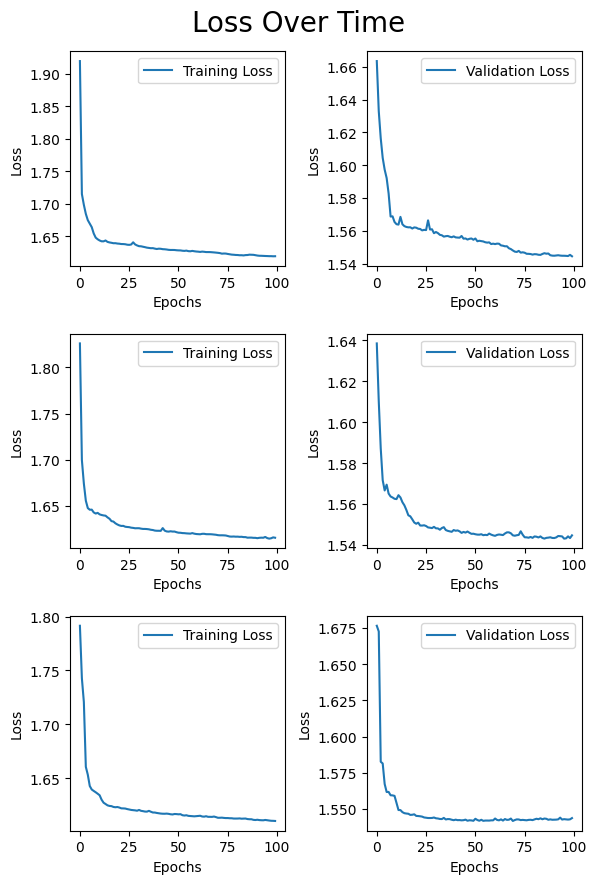

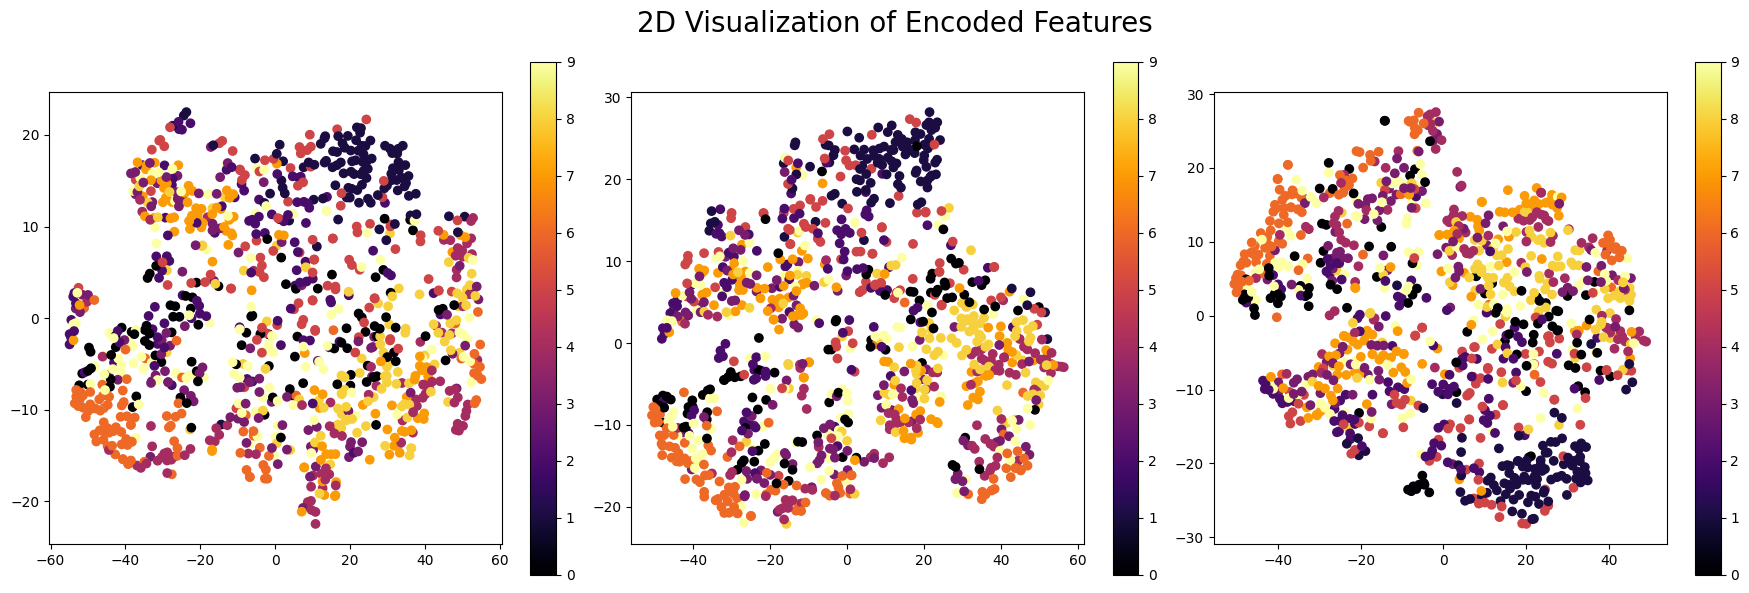

In [10]:
settings = (TestModel.ModelSettings(100, 64), TestModel.ModelSettings(100, 32), TestModel.ModelSettings(100, 16))
tm = TestModel(model_5, settings)
tm.test(X, X, validation_split=0.1, X_test=X, Y_test=Y, output_shape=30)

## Model 6

In [6]:
def model_6():
    input_shape = (130, 560)
    encoding_dim = 10
    
    # 編碼器
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv1D(32, 3, activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling1D(2, padding='same')(x)  # shape[0] // 2 -> 65 * 32
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2, padding='same')(x)  # shape[0] // 2 -> 33 * 64
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2, padding='same')(x)  # shape[0] // 2 -> 17 * 128
    
    # 壓縮成 latent space
    x = layers.Conv1D(512, 3, activation='relu', padding='same')(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    encoded = layers.Dense(encoding_dim, activation='relu')(x)
    
    # 解碼器
    x = layers.Dense(17*encoding_dim, activation='relu')(encoded)  # 將大小恢復
    x = layers.Reshape((17, encoding_dim))(x)  # 恢復到 (17, encoding_dim)
    x = layers.Conv1DTranspose(128, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(2)(x)  # shape -> 34
    x = layers.Conv1DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(2)(x)  # shape -> 68
    x = layers.Conv1DTranspose(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(2)(x)  # shape -> 136
    
    # 修正 shape
    x = layers.Cropping1D(cropping=(3, 3))(x)  # 將形狀修正為 130
    
    # 重構輸出
    decoded = layers.Conv1D(input_shape[1], 3, activation='sigmoid', padding='same')(x)
    
    encoder = models.Model(input_layer, encoded)
    autoencoder = models.Model(input_layer, decoded)
    
    return encoder, autoencoder

encoder, autoencoder = model_6()
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 130, 560)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 130, 32)        │        53,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 65, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 65, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 33, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 33, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 17, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 17, 512)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 170)            │         1,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 17, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 17, 128)        │         3,968 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 34, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 34, 64)         │        24,640 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 68, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 68, 32)         │         6,176 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 136, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d (Cropping1D)         │ (None, 130, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 130, 560)       │        54,32

 Total params: 710,024 (2.71 MB)

 Trainable params: 710,024 (2.71 MB)

 Non-trainable params: 0 (0.00 B)

# Model - 1
Epoch 7/100 - loss: 1.6734 - val_loss: 1.5986

KeyboardInterrupt: 

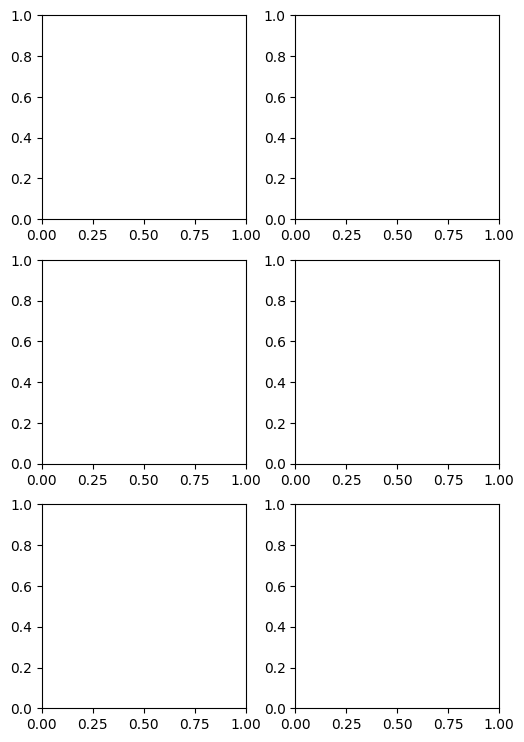

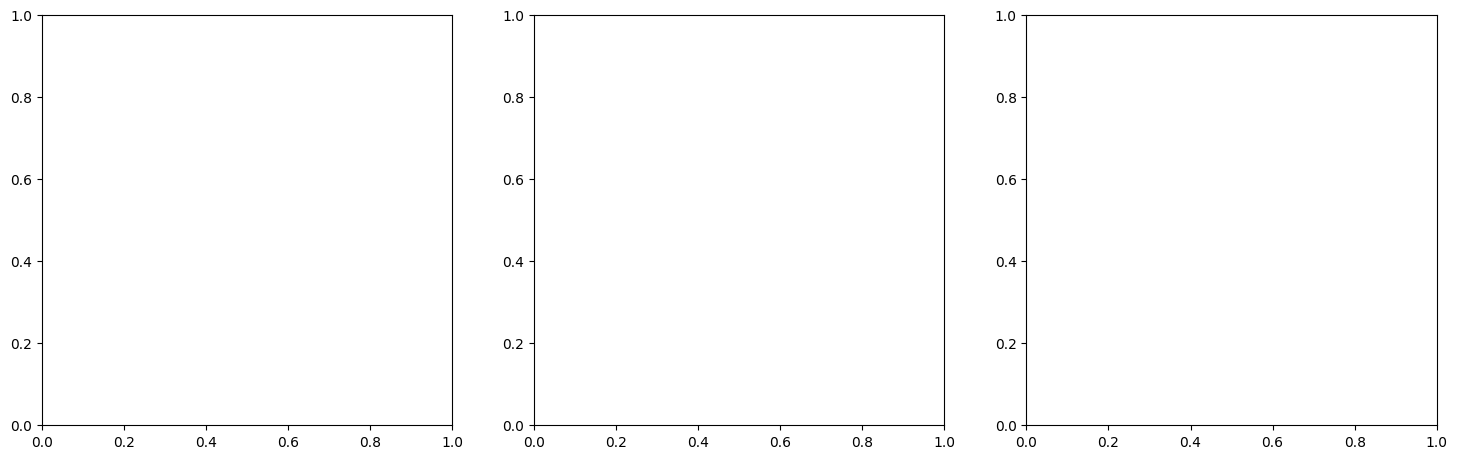

In [31]:
settings = (TestModel.ModelSettings(100, 64), TestModel.ModelSettings(100, 32), TestModel.ModelSettings(100, 16))
tm = TestModel(model_6, settings)
tm.test(X, X, validation_split=0.1, X_test=X, Y_test=Y, output_shape=10)

## Model 7

In [13]:
def model_7():
    input_shape = (130, 560)
    encoding_dim = 20
    
    # 編碼器
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling1D(2, padding='same')(x)  # shape[0] // 2 -> 65 * 64
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2, padding='same')(x)  # shape[0] // 2 -> 33 * 128
    x = layers.Conv1D(256, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2, padding='same')(x)  # shape[0] // 2 -> 17 * 256
    
    # 壓縮成 latent space
    x = layers.Conv1D(512, 3, activation='relu', padding='same')(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    encoded = layers.Dense(encoding_dim, activation='relu')(x)
    
    # 解碼器
    x = layers.Dense(17*encoding_dim, activation='relu')(encoded)  # 將大小恢復
    x = layers.Reshape((17, encoding_dim))(x)  # 恢復到 (17, encoding_dim)
    x = layers.Conv1DTranspose(256, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(2)(x)  # shape -> 34
    x = layers.Conv1DTranspose(128, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(2)(x)  # shape -> 68
    x = layers.Conv1DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(2)(x)  # shape -> 136
    
    # 修正 shape
    x = layers.Cropping1D(cropping=(3, 3))(x)  # 將形狀修正為 130
    
    # 重構輸出
    decoded = layers.Conv1D(input_shape[1], 3, activation='sigmoid', padding='same')(x)
    
    encoder = models.Model(input_layer, encoded)
    autoencoder = models.Model(input_layer, decoded)
    
    return encoder, autoencoder

encoder, autoencoder = model_7()
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 130, 560)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 130, 64)        │       107,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 65, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 65, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 33, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 33, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 17, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 17, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 340)            │         7,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 17, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 17, 256)        │        15,616 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 34, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 34, 128)        │        98,432 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 68, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 68, 64)         │        24,640 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 136, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping1d (Cropping1D)         │ (None, 130, 64)        │             

 Total params: 1,314,920 (5.02 MB)

 Trainable params: 1,314,920 (5.02 MB)

 Non-trainable params: 0 (0.00 B)

# Model - 1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
# Model - 2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
# Model - 3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


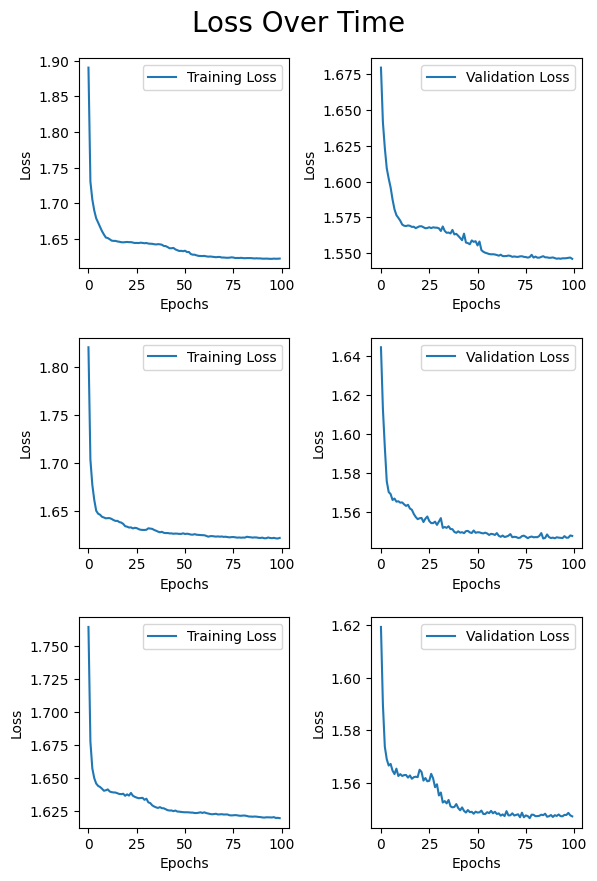

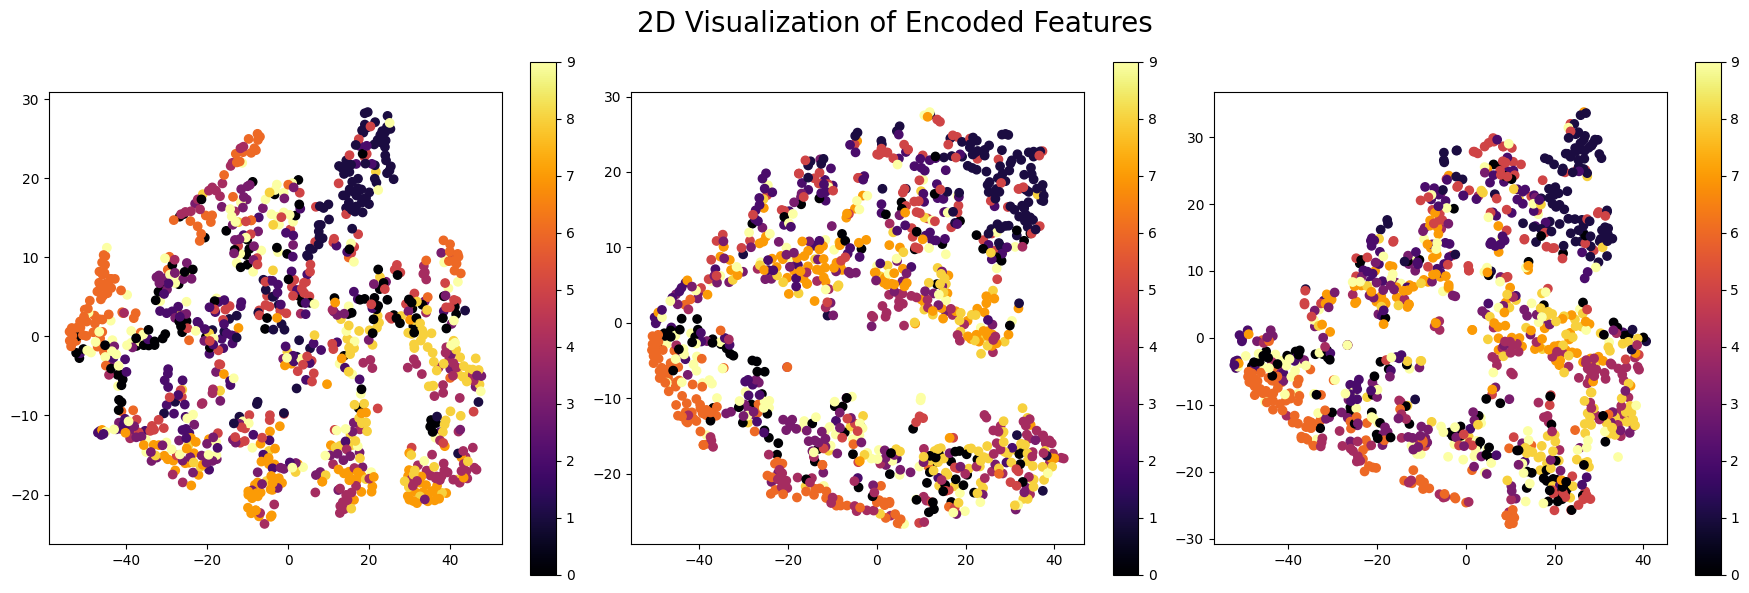

In [27]:
settings = (TestModel.ModelSettings(100, 64), TestModel.ModelSettings(100, 32), TestModel.ModelSettings(100, 16))
tm = TestModel(model_7, settings)
tm.test(X, X, validation_split=0.1, X_test=X, Y_test=Y, output_shape=20)

## Test

In [11]:
# X_test = np.expand_dims(X[0], 0)
# X_test.shape
# encoder.predict(X_test)

In [14]:
print(np.unique(Y))
print(Y.shape, X.shape)

['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']
(1000,) (1000, 130, 560, 1)


In [9]:
encoder, decoder = model_6()
decoder.compile(optimizer='adam', loss='mse')
hist = decoder.fit(X, X, epochs=50, batch_size=32, validation_split=0.1)

NameError: name 'model_6' is not defined

In [33]:
print(encoder.get_weights())

[array([[[ 0.03218586, -0.03716699,  0.04181476, ...,  0.03299268,
         -0.06155618, -0.07711311],
        [-0.02657182,  0.01691986,  0.00558372, ..., -0.02681326,
          0.00539241,  0.00373196],
        [-0.08247663,  0.01108019, -0.00284922, ..., -0.0027551 ,
          0.02787636, -0.03125783],
        ...,
        [ 0.02498201, -0.04168362, -0.01288272, ...,  0.06393913,
         -0.00533443, -0.03874147],
        [-0.02967552, -0.00469836,  0.00563202, ..., -0.0484069 ,
         -0.00902498, -0.02845601],
        [ 0.04987372,  0.04765822,  0.06353965, ..., -0.03327009,
          0.02244606,  0.08886616]],

       [[-0.00211766, -0.07070622, -0.01892235, ..., -0.02321441,
         -0.00702911,  0.05224923],
        [-0.05225566, -0.04949997,  0.00308008, ..., -0.00077771,
         -0.03727752,  0.0052519 ],
        [-0.05838221, -0.00878092, -0.02490314, ..., -0.01852532,
         -0.00866791, -0.02228067],
        ...,
        [-0.15475138, -0.03904447,  0.07174131, ..., 

In [10]:
def encode_Y(Y):
    le = LabelEncoder()
    return le.fit_transform(Y)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


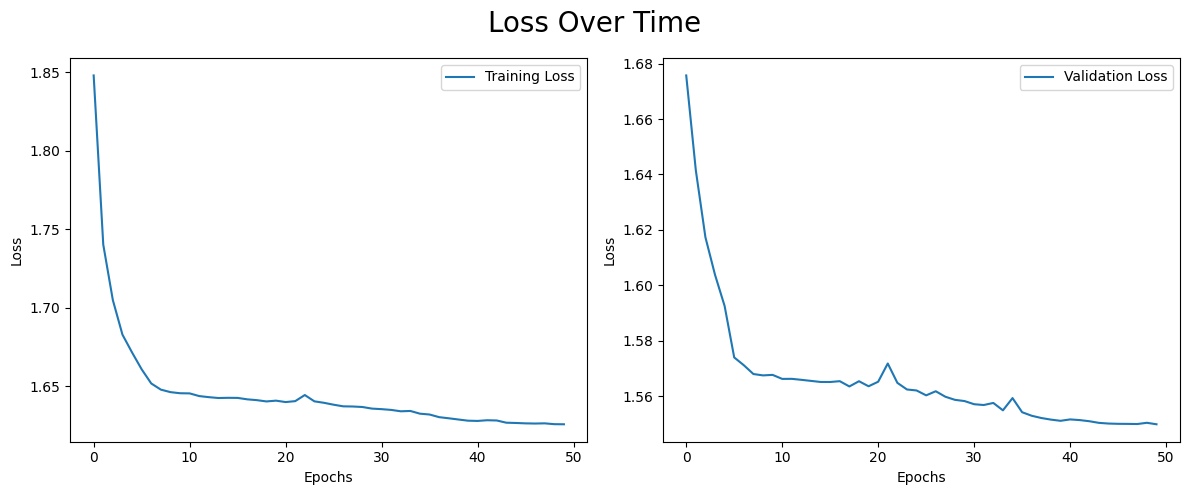

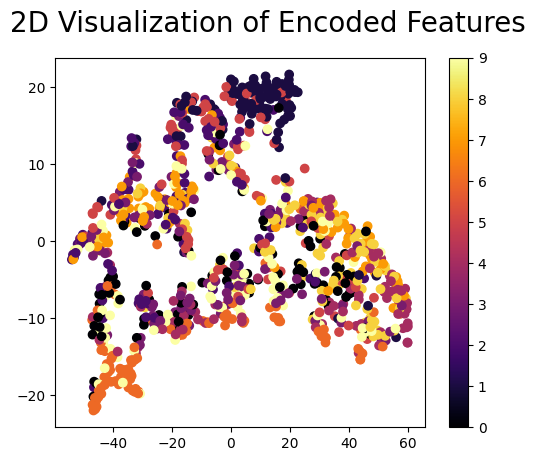

In [36]:
tm = TestModel(None, None)
tm._draw_loss(hist)
tm._draw_tsne(X, encode_Y(Y), encoder, output_shape=10)

In [11]:
def mfcc_to_X(filepath):
    audio = Audio(filepath=filepath, duration=30)
    _, _, mfcc = audio.get_mfcc(80, segment_size=10)
    mfcc = np.array(mfcc)
    mfcc = mfcc.transpose(2, 1, 0)
    mfcc = np.reshape(mfcc, (130, -1))
    mfcc = np.expand_dims(mfcc, axis=-1)
    mfcc = np.expand_dims(mfcc, axis=0)
    mfcc = np.nan_to_num(mfcc, nan = 0.)
    return mfcc
    
def get_features(filepath, encoder: models.Model):
    mfcc = mfcc_to_X(filepath)
    res = encoder.predict(mfcc)
    res = res.flatten()
    res = min_max_scaling(res)
    return res


In [12]:
def display_layers(X, encoder: models.Model):
    layer_outputs = [layer.output for layer in encoder.layers]
    activation_model = models.Model(inputs=encoder.input, outputs=layer_outputs)

    activations = activation_model.predict(X)

    # 打印每層的輸出，檢查是否有 NaN
    for layer_name, activation in zip([layer.name for layer in encoder.layers], activations):
        print(f"Layer {layer_name} has nan".ljust(40), "\t:", np.isnan(activation).any())

encoder = models.load_model("./models/best.h5")     
mfcc_X = mfcc_to_X(r".\data\music\download\AUDBVpvGAVs.mp3")
display_layers(mfcc_X, encoder)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Layer input_layer_5 has nan              	: False
Layer conv1d_25 has nan                  	: False
Layer max_pooling1d_15 has nan           	: False
Layer conv1d_26 has nan                  	: False
Layer max_pooling1d_16 has nan           	: False
Layer conv1d_27 has nan                  	: False
Layer max_pooling1d_17 has nan           	: False
Layer conv1d_28 has nan                  	: False
Layer global_max_pooling1d_5 has nan     	: False
Layer dense_28 has nan                   	: False
Layer dense_29 has nan                   	: False
Layer dense_30 has nan                   	: False
Layer dense_31 has nan                   	: False


In [13]:
musics = [i for i in os.listdir(r".\data\music\download/") if i.endswith(".mp3")]
print(musics)

features = np.array([get_features(r".\data\music\download/" + i, encoder) for i in musics])

['AUDBVpvGAVs.mp3', 'H1Dvg2MxQn8.mp3', 'pHlqEvAwdVc.mp3', 'RhPX1bt0yWw.mp3', 'shs0rAiwsGQ.mp3', 'Z2IHNAjrnNI.mp3']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [14]:
print(features)

[[0.         0.4076947  0.         0.         0.9750372  0.94664735
  0.         0.7328485  0.30619192 1.        ]
 [0.         0.49528858 0.         0.         1.         0.98295677
  0.         0.80939883 0.33707213 0.9549719 ]
 [0.         0.47000608 0.         0.         1.         0.9827751
  0.         0.79449165 0.3293664  0.99223053]
 [0.         0.46379197 0.         0.         1.         0.94647014
  0.         0.77397776 0.33356404 0.9955973 ]
 [0.         0.41683087 0.         0.         0.9819394  0.95227355
  0.         0.7355825  0.310602   1.        ]
 [0.         0.5095849  0.         0.         1.         0.8413611
  0.         0.74833983 0.37493947 0.87810147]]


In [ ]:
res = cosine_similarity(features)
p_res = res**1000 * 100
        
show_matrix(musics, p_res)

TypeError: unsupported operand type(s) for -: 'int' and 'list'

In [51]:
import heapq
def get_top(similarity, target_idx, n):
    if type(target_idx) == str:
        target_idx = musics.index(target_idx)
    data = similarity[target_idx].tolist()
    top = heapq.nlargest(n, enumerate(data), key=lambda x: x[1])
    for t in top:
        print(f"{t[0]} ({musics[t[0]]}): {min(100, t[1])/100:.2%}")
    # print(similarity[0].tolist())

get_top(p_res, "flower_dance_1.mp3", 10)

43 (flower_dance_1.mp3): 100.00%
2 (-tKVN2mAKRI.mp3): 91.05%
44 (flower_dance_2.mp3): 88.62%
19 (9aJVr5tTTWk.mp3): 86.39%
67 (K_xTet06SUo.mp3): 79.27%
46 (gJX2iy6nhHc.mp3): 71.33%
50 (Hh9yZWeTmVM.mp3): 70.46%
13 (51CH3dPaWXc.mp3): 69.85%
28 (Ct6BUPvE2sM.mp3): 69.38%
86 (qLMLzBYTTKQ.mp3): 67.68%


In [ ]:
print(np.unique(Y))
print(Y.shape, X.shape)

['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']
(1000,) (1000, 130, 560, 1)


In [54]:
# encoder.save("./models/best.h5")